# Modelization


### Importing libraries

In [1]:
import pandas as pd
pd.set_option("max_columns", 50)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import tree
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from collections import OrderedDict, defaultdict
from sklearn.externals import joblib
from sklearn.metrics import r2_score, mean_squared_error

### Convenience functions
* Chart Results: Compares target with predicted data:

In [2]:
def chartResults(y, predBest, trainTest, model=None):
    
    '''
    Example of use
    chartResults(y=y_train, predBest=predTrain, trainTest='Train', model='Decision Trees')
    '''
    
    plt.figure(figsize=(6, 4))
    plt.scatter(y, predBest, s=20,alpha=0.1)
    plt.title(model + '\nPredicted Price vs. Real Price. \n' + trainTest + ' dataset')
    plt.xlabel('Real Price')
    plt.ylabel('Predicted Price')
    plt.plot([min(y), max(y)], [min(y), max(y)], 'y')
    
#    return plt.tight_layout()
    return plt.show()

* Results data frame:

In [3]:
modelizationResults = pd.DataFrame({'Algorithm': [], 
                                    'Fine_Tuning': [],
                                    'R2_Train': [], 
                                    'R2_Test': [], 
                                    'MSE_Train': [], 
                                    'MSE_Test': []})
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test


In [4]:
def rowOfResults(Algorithm, Fine_Tuning, R2_Train, R2_Test, MSE_Train, MSE_Test):
    '''
    Example:
    rowOfResults('Decision trees', True, 2, 3, 4, 5)
    '''
    tempResults = pd.DataFrame({'Algorithm': [Algorithm], 
                                'Fine_Tuning': [Fine_Tuning],
                                'R2_Train': [np.round(R2_Train, 3)],
                                'R2_Test': [np.round(R2_Test, 3)],
                                'MSE_Train': [np.round(MSE_Train, 0)],
                                'MSE_Test': [np.round(MSE_Test, 0)]})
    return tempResults

### Reading clean dataset


In [5]:
datasetCarsFinal = pd.read_csv('../data/autosFinal.csv',
                               usecols=[
                                      #'brand', 
                                      #'model', 
                                      'brandModel',
                                      'vehicleType', 
                                      'gearbox', 
                                      'yearOfRegistration',
                                      'fuelType',
                                      'powerPS',
                                      'kilometer',
                                      #'kilometerCategorical',
                                      #'kilometer000',
                                      'notRepairedDamage',
                                      #'postalCode',
                                      'state',
                                      #'community',
                                      'price'
                                      ],
                               dtype={
                                      #'brand': 'str', 
                                      #'model': 'str', 
                                      'brandModel': 'str', 
                                      'vehicleType': 'str', 
                                      'gearbox': 'str', 
                                      'yearOfRegistration': np.int64,
                                      'fuelType': 'str',
                                      'powerPS': np.int64,
                                      'kilometer': np.int64,
                                      #'kilometerCategorical': 'str',
                                      #'kilometer000': np.int64,
                                      'notRepairedDamage': 'str',
                                      #'postalCode': 'str',
                                      'state': 'str',
                                      #'community':'str',
                                      'price': np.int64
                                      })

In [6]:
datasetCarsFinal.columns

Index(['state', 'price', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerPS', 'fuelType', 'notRepairedDamage', 'kilometer', 'brandModel'],
      dtype='object')

In [7]:
datasetCarsFinal.head()

,state,price,vehicleType,yearOfRegistration,gearbox,powerPS,fuelType,notRepairedDamage,kilometer,brandModel
0,Bayern,9800,suv,2004,automatik,163,diesel,nein,125000,jeep grand
1,Bayern,1500,kleinwagen,2001,manuell,75,benzin,nein,150000,volkswagen golf
2,Hessen,3600,kleinwagen,2008,manuell,69,diesel,nein,90000,skoda fabia
3,Nordrhein-Westfalen,650,limousine,1995,manuell,102,benzin,ja,150000,bmw 3er
4,Rheinland-Pfalz,2200,cabrio,2004,manuell,109,benzin,nein,150000,peugeot 2_reihe


***

## Data setup
### Splitting dataset into target, and numerical and categorical predictors
This is necessary in order to use LabelEncoder only on categorical features

In [8]:
target = datasetCarsFinal['price']
numerical = datasetCarsFinal[['yearOfRegistration', 'powerPS', 'kilometer']]
categorical = datasetCarsFinal.drop(['yearOfRegistration', 'powerPS', 'kilometer', 'price'], axis=1)

Now, we can apply Label encoder to each categorical column and rejoin columns in a new data frame

In [9]:
d = defaultdict(LabelEncoder)
categorical_encoded = categorical.apply(lambda x: d[x.name].fit_transform(x))
datasetCarsFinalConcat = pd.concat([categorical_encoded, numerical], axis=1)

For later use, we will save label encoding using joblib

In [7]:
joblib.dump(d, '../output/carsLabelEncoder.pkl')

['../output/carsLabelEncoder.pkl']

### Create train and test datasets

In [10]:
np.random.seed(42)
train, test = train_test_split(datasetCarsFinalConcat.index, test_size = 0.2)

X_train = datasetCarsFinalConcat.loc[train]
y_train = target.loc[train]

X_test = datasetCarsFinalConcat.loc[test]
y_test = target.loc[test]

In [11]:
X_train.shape, y_train.shape 

((205724, 9), (205724,))

In [12]:
X_test.shape, y_test.shape

((51431, 9), (51431,))

Now, data is ready to modelization process

***

## Decision Trees
Our first try will be Decision Trees algorithm. No hyperparameters will be tuned for the moment:

In [13]:
regrDT = tree.DecisionTreeRegressor().fit(X_train, y_train)

In [14]:
predDTTrain = regrDT.predict(X_train)
predDTTest = regrDT.predict(X_test)

### Model scores:  
* $R^2$ Score:

In [15]:
R2DTTrain = r2_score(y_train, predDTTrain)
R2DTTest = r2_score(y_test, predDTTest)
print('R2 Train: %.3f' % R2DTTrain, '\nR2 Test:  %.3f' % R2DTTest)

R2 Train: 0.991 
R2 Test:  0.812


* MSE Score:

In [16]:
MSEDTTrain = mean_squared_error(y_train, predDTTrain)
MSEDTTest = mean_squared_error(y_test, predDTTest)
print('MSE Train:', format(MSEDTTrain, ',f'), '\nMSE Test:', format(MSEDTTest, ',f'))

MSE Train: 544,289.062484 
MSE Test: 12,364,101.525513


In [17]:
DTResults = rowOfResults('Decision trees', False, R2DTTrain, R2DTTest, MSEDTTrain, MSEDTTest)
DTResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Decision trees,False,0.991,0.812,544289.0,12364102.0


In [18]:
modelizationResults = modelizationResults.append(DTResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Decision trees,0.0,0.991,0.812,544289.0,12364102.0


Almost perfect with train data, but low $R²$ in test

Not bad results, but maybe some signals of overfitting. Let's go to some fine tuning on hyperparameters and cross validation to improve results.  
### Hyperparameter tuning

In [19]:
paramGridDT = {
        'criterion': ['mse'],
        'splitter': ['best', 'random'],
        'max_depth': list(range(1, 20 + 1)),
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [1],
        'max_features': ['auto']
        }

**ATTENTION**: With this paramGrid cross validation takes 2 minutes to complete

In [20]:
cvDT = GridSearchCV(
        estimator = tree.DecisionTreeRegressor(),
        param_grid=paramGridDT,
        n_jobs=-1,
        cv=10,
        refit=False,
        verbose=1,
        return_train_score=True).fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 958 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.8min finished


These are the best parameters:

In [21]:
cvDT.best_params_

{'criterion': 'mse',
 'max_depth': 18,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'splitter': 'best'}

In [22]:
bestDecisionTree = tree.DecisionTreeRegressor(criterion=cvDT.best_params_['criterion'],
                                              max_depth=cvDT.best_params_['max_depth'],
                                              max_features=cvDT.best_params_['max_features'],
                                              min_samples_leaf=cvDT.best_params_['min_samples_leaf'],
                                              min_samples_split=cvDT.best_params_['min_samples_split'],
                                              splitter=cvDT.best_params_['splitter']).fit(X_train, y_train)

In [23]:
predBestDTTrain = bestDecisionTree.predict(X_train)
predBestDTTest = bestDecisionTree.predict(X_test)

And the scores now are:

* $R^2$ Score:

In [24]:
R2BestDTTrain = r2_score(y_train, predBestDTTrain)
R2BestDTTest = r2_score(y_test, predBestDTTest)
print('R2 Train: %.3f' % R2BestDTTrain, '\nR2 Test: %.3f' % R2BestDTTest)

R2 Train: 0.932 
R2 Test: 0.852


* MSE Score:

In [25]:
MSEBestDTTrain = mean_squared_error(y_train, predBestDTTrain)
MSEBestDTTest = mean_squared_error(y_test, predBestDTTest)
print('MSE Train:', format(MSEBestDTTrain, ',f'), '\nMSE Test:', format(MSEBestDTTest, ',f'))

MSE Train: 4,301,121.631663 
MSE Test: 9,734,744.276339


In [26]:
DTBestResults = rowOfResults('Decision trees', True, R2BestDTTrain, R2BestDTTest, MSEBestDTTrain, MSEBestDTTest)
DTBestResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Decision trees,True,0.932,0.852,4301122.0,9734744.0


In [27]:
modelizationResults = modelizationResults.append(DTBestResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Decision trees,0.0,0.991,0.812,544289.0,12364102.0
0,Decision trees,1.0,0.932,0.852,4301122.0,9734744.0


We have improved test results but losing precision in test data.

## Charting results

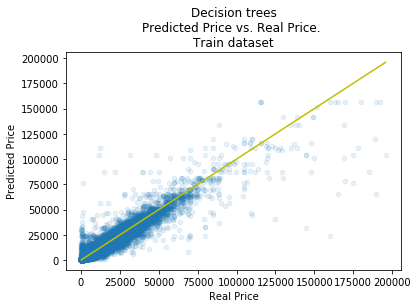

In [28]:
chartResults(y=y_train, predBest=predBestDTTrain, trainTest='Train', model='Decision trees')

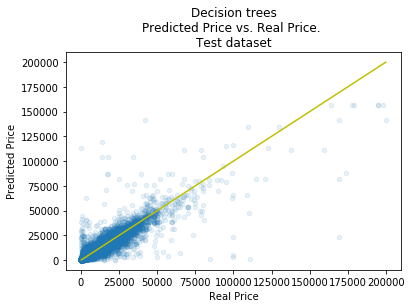

In [29]:
chartResults(y=y_test, predBest=predBestDTTest, trainTest='Test', model='Decision trees')

In [30]:
bestDecisionTree.feature_importances_

array([ 0.00670751,  0.03798005,  0.00675597,  0.00543586,  0.00467388,
        0.10333363,  0.46189176,  0.33095634,  0.04226502])

In [31]:
X_train.columns

Index(['state', 'vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage',
       'brandModel', 'yearOfRegistration', 'powerPS', 'kilometer'],
      dtype='object')

<BarContainer object of 9 artists>

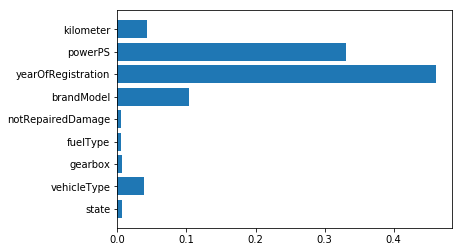

In [32]:
plt.barh(X_train.columns, bestDecisionTree.feature_importances_)

### Saving the model for later use

In [64]:
joblib.dump(bestDecisionTree, filename='../output/bestDecisionTree.pkl')

['../output/bestDecisionTree.pkl']

***

# Random forest
This will be the second algorithm we are going to use in order to improve results obtained with Decision Trees. Let's try to model without hyperparamenter tuning.

In [78]:
regrRF = RandomForestRegressor(n_jobs=-1,
                               verbose=1).fit(X_train,
                                              y_train)

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


In [79]:
predRFTrain = regrRF.predict(X_train)
predRFTest = regrRF.predict(X_test)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


### Model scores:  
* $R^2$ Score:

In [80]:
R2RFTrain = r2_score(y_train, predRFTrain)
R2RFTest = r2_score(y_test, predRFTest)
print('R2 Train: %.3f' % R2RFTrain, '\nR2 Test:  %.3f' % R2RFTest)

R2 Train: 0.971 
R2 Test:  0.865


* MSE Score:

In [81]:
MSERFTrain = mean_squared_error(y_train, predRFTrain)
MSERFTest = mean_squared_error(y_test, predRFTest)
print('MSE Train:', format(MSERFTrain, ',f'), '\nMSE Test:', format(MSERFTest, ',f'))

MSE Train: 1,829,807.055354 
MSE Test: 8,850,278.075400


In [82]:
RFResults = rowOfResults('Random Forest', False, R2RFTrain, R2RFTest, MSERFTrain, MSERFTest)
RFResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Random Forest,False,0.971,0.865,1829807.0,8850278.0


In [83]:
modelizationResults = modelizationResults.append(RFResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Decision trees,0.0,0.987,0.808,848865.0,12569415.0
0,Decision trees,1.0,0.934,0.854,4142864.0,9612916.0
0,Decision trees,1.0,0.971,0.872,1848684.0,8406011.0
0,Random Forest,0.0,0.971,0.872,1848684.0,8406011.0
0,Random Forest,0.0,0.971,0.865,1829807.0,8850278.0


### Hyperparameter tuning
Test the optimum number of features

In [84]:
np.random.seed(123)
scores = {}

rf = None

for max_features in [2,4,8, 'auto', None]:
    if rf is None:
        rf = RandomForestRegressor(n_estimators=50,
                                   max_features=max_features)
    else:
        rf.warm_start = False
        rf.max_features = max_features
    
    rf = rf.fit(X_train, y_train)
    scores[max_features] = rf.score(X_test, y_test)

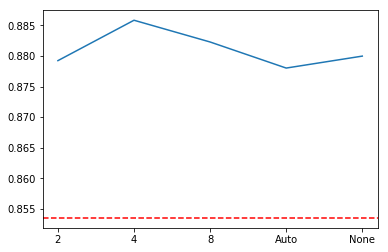

In [85]:
plt.plot([2, 4, 8, 'Auto', 'None'], scores.values())
plt.axhline(bestDecisionTree.score(X_test, y_test), linestyle='dashed', color='red')

In [125]:
paramsRF = {
        'n_estimators': [50, 100, 200],
        'max_features': [4],
        'max_depth': list(range(1, 10 + 1)),
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf':[1]
        }

This param grid takes 1 hours

In [126]:
cvRF = GridSearchCV(
        estimator=RandomForestRegressor(oob_score=True),
        param_grid=paramsRF,
        n_jobs=-1,
        cv=10,
        verbose=1,
        return_train_score=True).fit(X_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 42.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 53.1min finished


In [127]:
cvRF.best_params_

{'max_depth': 10,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [130]:
bestRandoForest = RandomForestRegressor(max_depth=cvRF.best_params_['max_depth'], 
                                        max_features=cvRF.best_params_['max_features'], 
                                        min_samples_leaf=cvRF.best_params_['min_samples_leaf'], 
                                        min_samples_split=cvRF.best_params_['min_samples_split'], 
                                        n_estimators=cvRF.best_params_['n_estimators']).fit(X_train, y_train)

In [131]:
predBestRFTrain = bestRandoForest.predict(X_train)
predBestRFTest = bestRandoForest.predict(X_test)

### Model scores:  
* $R^2$ Score:

In [132]:
R2BestRFTrain = r2_score(y_train, predBestRFTrain)
R2BestRFTest = r2_score(y_test, predBestRFTest)
print('R2 Train: %.3f' % R2BestRFTrain, '\nR2 Test: %.3f' % R2BestRFTest)

R2 Train: 0.890 
R2 Test: 0.858


* MSE Score:

In [133]:
MSEBestRFTrain = mean_squared_error(y_train, predBestRFTrain)
MSEBestRFTest = mean_squared_error(y_test, predBestRFTest)
print('MSE Train:', format(MSEBestRFTrain, ',f'), '\nMSE Test:', format(MSEBestRFTest, ',f'))

MSE Train: 6,947,069.623636 
MSE Test: 9,306,430.403108


In [77]:
RFBestResults = rowOfResults('Random Forest', True, R2BestRFTrain, R2BestRFTest, MSEBestRFTrain, MSEBestRFTest)
RFBestResults

NameError: name 'R2BestRFTrain' is not defined

In [76]:
modelizationResults = modelizationResults.append(RFBestResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Decision trees,0.0,0.987,0.808,848865.0,12569415.0
0,Decision trees,1.0,0.934,0.854,4142864.0,9612916.0
0,Decision trees,1.0,0.971,0.872,1848684.0,8406011.0
0,Random Forest,0.0,0.971,0.872,1848684.0,8406011.0


## Charting results

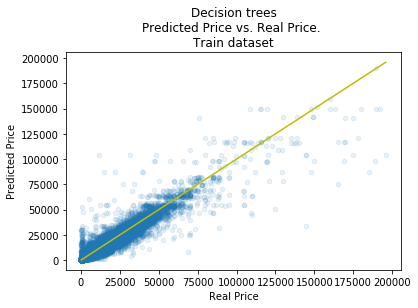

In [62]:
chartResults(y=y_train, predBest=predBestRFTrain, trainTest='Train', model='Random Forest')

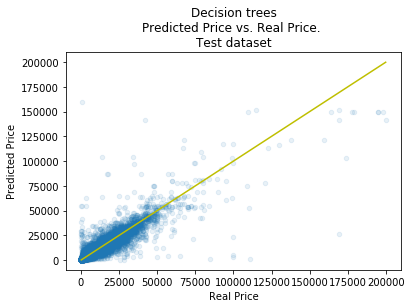

In [63]:
chartResults(y=y_test, predBest=predBestRFTest, trainTest='Test', model='Random Forest')

### Saving the model for later use

In [136]:
joblib.dump(bestRandoForest, filename='../output/bestRandomForest.pkl')

['../output/bestRandomForest.pkl']

***

# K-nearest neighbours

First try, no hyperparameter tuning

In [87]:
regrKNN = neighbors.KNeighborsRegressor(n_jobs=-1).fit(X_train, y_train)

In [88]:
predKNNTrain = regrKNN.predict(X_train)
predKNNTest = regrKNN.predict(X_test)

### Model score:  
* $R^2$ Score:

In [180]:
R2KNNTrain = r2_score(y_train, predKNNTrain)
R2KNNTest = r2_score(y_test, predKNNTest)
print('R2 Train: %.3f' % R2KNNTrain, '\nR2 Test:  %.3f' % R2KNNTest)

R2 Train: 0.910 
R2 Test:  0.840


* MSE Score:

In [181]:
MSEKNNTrain = mean_squared_error(y_train, predKNNTrain)
MSEKNNTest = mean_squared_error(y_test, predKNNTest)
print('MSE Train:', format(MSEKNNTrain, ',f'), '\nMSE Test:', format(MSEKNNTest, ',f'))

MSE Train: 5,713,447.486862 
MSE Test: 10,486,847.513610


In [60]:
KNNResults = rowOfResults('K-nearest neighbours', False, R2KNNTrain, R2KNNTest, MSEKNNTrain, MSEKNNTest)
KNNResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Decision trees,True,0.934,0.854,4142864.0,9612916.0


In [66]:
modelizationResults = modelizationResults.append(KNNResults)
modelizationResults

### Hyperparameter tuning

In [167]:
# Cross Validation
paramsKNN = {
        'n_neighbors': [5, 10, 20],
        'weights': ['distance', 'uniform'],
        'algorithm': ['auto'],
        'leaf_size': [2,3,4],
        }

This params grid takes 5 minutes

In [168]:
cvKNN = GridSearchCV(
        estimator=neighbors.KNeighborsRegressor(),
        param_grid=paramsKNN,
        n_jobs=-1,
        cv=10,
        verbose=1,
        return_train_score=True).fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.8min finished


In [169]:
cvKNN.best_params_

{'algorithm': 'auto', 'leaf_size': 3, 'n_neighbors': 5, 'weights': 'distance'}

In [170]:
bestKNN = neighbors.KNeighborsRegressor(algorithm=cvKNN.best_params_['algorithm'], 
                                        leaf_size=cvKNN.best_params_['leaf_size'],
                                        n_neighbors=cvKNN.best_params_['n_neighbors'],
                                        weights=cvKNN.best_params_['weights']).fit(X_train, y_train)

In [172]:
predBestKNNTrain = bestKNN.predict(X_train)
predBestKNNTest = bestKNN.predict(X_test)

### Model score:  
* $R^2$ Score:

In [173]:
R2BestKNNTrain = r2_score(y_train, predBestKNNTrain)
R2BestKNNTest = r2_score(y_test, predBestKNNTest)
print('R2 Train: %.3f' % R2BestKNNTrain, '\nR2 Test: %.3f' % R2BestKNNTest)

R2 Train: 0.986 
R2 Test: 0.857


* MSE Score:

In [174]:
MSEBestKNNTrain = mean_squared_error(y_train, predBestKNNTrain)
MSEBestKNNTest = mean_squared_error(y_test, predBestKNNTest)
print('MSE Train:', format(MSEBestKNNTrain, ',f'), '\nMSE Test:', format(MSEBestKNNTest, ',f'))

MSE Train: 872,528.983937 
MSE Test: 9,413,727.364283


In [60]:
KNNBestResults = rowOfResults('K-nearest neighbours', True, R2BestKNNTrain, R2BestKNNTest, MSEBestKNNTrain, MSEBestKNNTest)
KNNBestResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Decision trees,True,0.934,0.854,4142864.0,9612916.0


In [66]:
modelizationResults = modelizationResults.append(KNNBestResults)
modelizationResults

## Charting results
Train data

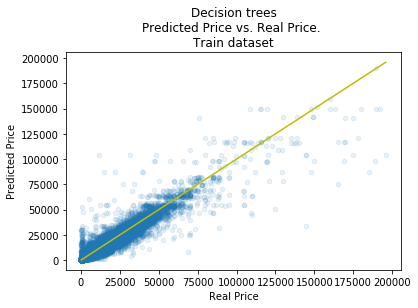

In [62]:
chartResults(y=y_train, predBest=predBestKNNTrain, trainTest='Train', model='K-nearest Neighbours')

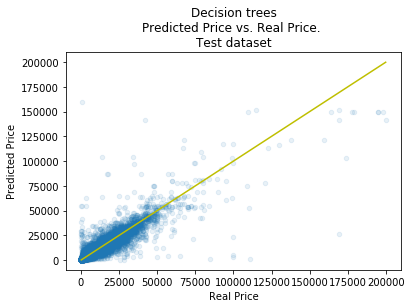

In [63]:
chartResults(y=y_test, predBest=predBestKNNTest, trainTest='Test', model='K-nearest Neighbours')

### Saving the model for later use

In [177]:
joblib.dump(bestKNN, filename='../output/bestKNN.pkl')

['../output/bestKNN.pkl']

***

# Gradient boosting

First try, no hyperparameters tuning

In [33]:
regrBoost = GradientBoostingRegressor().fit(X_train, y_train)

In [34]:
predBoostTrain = regrBoost.predict(X_train)
predBoostTest = regrBoost.predict(X_test)

### Model score:  
* $R^2$ Score:

In [35]:
R2BoostTrain = r2_score(y_train, predBoostTrain)
R2BoostTest = r2_score(y_test, predBoostTest)
print('R2 Train: %.3f' % R2BoostTrain, '\nR2 Test:  %.3f' % R2BoostTest)

R2 Train: 0.823 
R2 Test:  0.813


* MSE Score:

In [36]:
MSEBoostTrain = mean_squared_error(y_train, predBoostTrain)
MSEBoostTest = mean_squared_error(y_test, predBoostTest)
print('MSE Train:', format(MSEBoostTrain, ',f'), '\nMSE Test:', format(MSEBoostTest, ',f'))

MSE Train: 11,192,150.881908 
MSE Test: 12,263,782.808024


In [37]:
BoostResults = rowOfResults('Gradient Boosting', False, R2BoostTrain, R2BoostTest, MSEBoostTrain, MSEBoostTest)
BoostResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Gradient Boosting,False,0.823,0.813,11192151.0,12263783.0


In [38]:
modelizationResults = modelizationResults.append(BoostResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Decision trees,0.0,0.991,0.812,544289.0,12364102.0
0,Decision trees,1.0,0.932,0.852,4301122.0,9734744.0
0,Gradient Boosting,0.0,0.823,0.813,11192151.0,12263783.0


<BarContainer object of 9 artists>

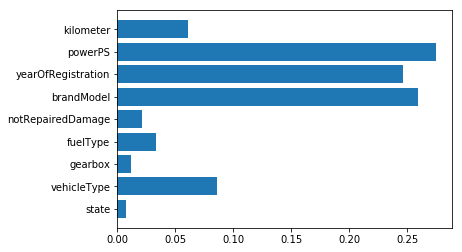

In [39]:
plt.barh(X_train.columns, regrBoost.feature_importances_)

### Hyperparameter tuning

**ATTENTION** This paramgrid takes 3 hours to complete

In [15]:
paramsBoost = {
        'learning_rate': [0.001, 0.01, 0.1],
        'n_estimators': [100, 200, 500],
        'max_depth': [1, 3, 5],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'max_features': [None, 'auto']
        }

In [16]:
cvBoost = GridSearchCV(
        estimator=GradientBoostingRegressor(),
        param_grid=paramsBoost,
        n_jobs=-1,
        cv=10,
        verbose=1,
        return_train_score=True).fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 67.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 131.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 176.7min finished


In [17]:
cvBoost.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [18]:
bestBoost = GradientBoostingRegressor(learning_rate=cvBoost.best_params_['learning_rate'],
                                      max_depth=cvBoost.best_params_['max_depth'],
                                      max_features=cvBoost.best_params_['max_features'],
                                      min_samples_leaf=cvBoost.best_params_['min_samples_leaf'],
                                      min_samples_split=cvBoost.best_params_['min_samples_split'],
                                      n_estimators=cvBoost.best_params_['n_estimators']).fit(X_train, y_train)

In [20]:
predBestBoostTrain = bestBoost.predict(X_train)
predBestBoostTest = bestBoost.predict(X_test)

* $R^2$ Score:

In [89]:
R2BestBoostTrain = r2_score(y_train, predBestBoostTrain)
R2BestBoostTest = r2_score(y_test, predBestBoostTest)
print('R2 Train: %.3f' % R2BestBoostTrain, '\nR2 Test: %.3f' % R2BestBoostTest)

R2 Train: 0.929 
R2 Test: 0.887


* MSE Score:

In [22]:
MSEBestBoostTrain = mean_squared_error(y_train, predBestBoostTrain)
MSEBestBoostTest = mean_squared_error(y_test, predBestBoostTest)
print('MSE Train:', format(MSEBestBoostTrain, ',f'), '\nMSE Test:', format(MSEBestBoostTest, ',f'))

MSE Train: 4,496,420.989134 
MSE Test: 7,431,329.559754


In [60]:
BoostBestResults = rowOfResults('Gradient Boosting', False, R2BestBoostTrain, R2BestBoostTest, MSEBestBoostTrain, MSEBestBoostTest)
BoostBestResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Decision trees,True,0.934,0.854,4142864.0,9612916.0


In [66]:
modelizationResults = modelizationResults.append(BoostBestResults)
modelizationResults

## Charting results

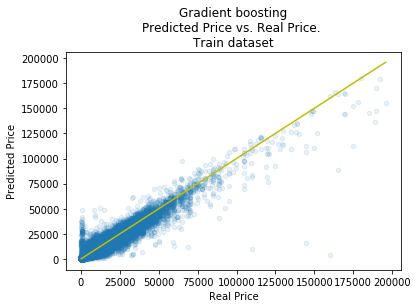

In [25]:
chartResults(y=y_train, predBest=predBestBoostTrain, trainTest='Train', model='Gradient boosting')

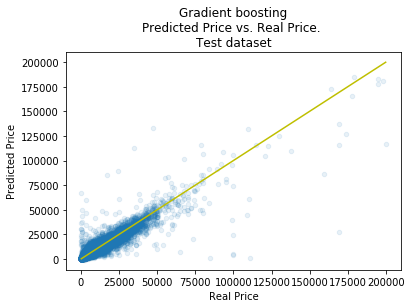

In [26]:
chartResults(y=y_test, predBest=predBestBoostTest, trainTest='Test', model='Gradient boosting')

### Saving the model for later use

In [27]:
joblib.dump(bestBoost, filename='../output/bestBoost.pkl')

['../output/bestBoost.pkl']

***

### Saving the results data frame

In [ ]:
joblib.dump(modelizationResults, filename='../output/modelizationResults.pkl')
modelizationResults.to_csv(path_or_buf='../output/modelizationResults.csv')

In [40]:
bestBoost.feature_importances_

NameError: name 'bestBoost' is not defined

In [96]:
X_train.columns

Index(['state', 'vehicleType', 'gearbox', 'kilometerCategorical', 'fuelType',
       'notRepairedDamage', 'brandModel', 'yearOfRegistration', 'powerPS'],
      dtype='object')